In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
targetdir = '/work/hmzhao/KMT_data/'
with h5py.File(targetdir + 'processed_data.h5', mode='r') as dataset_file:
    X_even = torch.tensor(dataset_file['X'][...]).float()
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)

In [3]:
q = torch.tensor([
    # Planet/Binary
    0.43, 0.10, 0.23, 0.045, 0.23,
    # Binary/Plan
    0.55, 0.18, 0.036, 0.048, 0.1,
    0.14, 0.17, 0.14, 0.13, 0.034,
    0.17, 0.43, 0.2,
    # Binary
    0.23, 0.356, 0.07, 0.50, 0.23, 
    0.17, 0.046, 0.4, 0.32, 0.19, 
    0.59, 0.86, 0.25, 0.37, 0.23,
    0.95, 0.58, 0.53, 0.046, 0.46,
    0.095, 0.90, 0.37, 0.36, 0.72,
    0.50, 0.11, 0.78, 0.42, 0.50,
    0.88, 0.73, 0.74, 0.15, 0.58,
    0.15, 0.43, 0.96, 0.086, 0.76,
    0.28, 0.67, 0.69, 0.23, 0.56,
    0.50, 0.08, 0.74, 0.67, 0.20
])

In [4]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_38720.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = 6
input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [5]:
def get_negloglik(pi, normal, y):
    normal = torch.distributions.Normal(normal.loc[:, :, [2]], normal.scale[:, :, [2]])
    loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
    loglik = torch.sum(loglik, dim=2)
    loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
    return loss


num = len(X_even)
batchsize = len(X_even)
pred = torch.zeros((num, 6))
nll = torch.zeros((num,))
nll_sample = torch.zeros((num,))
model.eval()
for i in tqdm(range(num // batchsize)):
    torch.cuda.empty_cache()
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    # pred[i*batchsize:i*batchsize+batchsize] = model(batch).detach().cpu()
    pi, normal = model(batch)
    pred[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal).detach().cpu()
    nll[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, torch.log10(q).reshape(-1, 1)[i*batchsize:i*batchsize+batchsize].float().to(device)).detach().cpu()
    nll_sample[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, pred[i*batchsize:i*batchsize+batchsize, [2]].float().to(device)).detach().cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

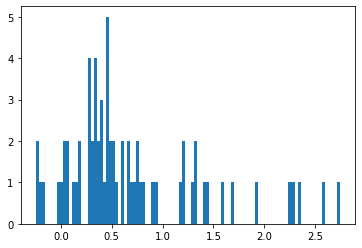

In [6]:
plt.hist(nll.numpy(), bins=100)
plt.show()

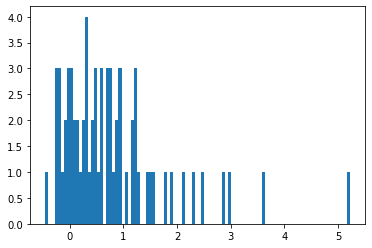

In [7]:
plt.hist(nll_sample.numpy(), bins=100)
plt.show()

In [8]:
10**pred[:, 2]


tensor([7.2223e-01, 8.6275e-01, 9.9091e-02, 4.4226e-03, 6.4275e-02, 4.2379e-02,
        6.2161e-02, 1.0434e+00, 6.7748e-01, 2.0474e-02, 3.0264e-01, 4.0850e-01,
        5.7949e-01, 1.4779e-01, 2.8796e-02, 4.5541e-02, 3.8425e-01, 5.7250e-02,
        2.1104e-01, 7.6169e-02, 8.3833e-01, 6.1551e-02, 1.4376e+00, 7.1329e-01,
        2.8362e-01, 4.8586e-01, 1.1674e-01, 5.1415e-01, 1.0376e-01, 2.8114e-01,
        1.8945e-01, 3.5700e-02, 2.1726e-01, 8.5320e-01, 1.5030e+00, 1.2316e+00,
        3.1495e-01, 2.2251e-01, 1.7958e+00, 6.8515e-01, 5.6188e-01, 1.3165e-03,
        1.6162e-01, 1.4494e-02, 1.8373e-01, 1.6465e-02, 1.3331e-02, 2.1353e-01,
        5.8124e-01, 1.7142e+00, 8.7762e-01, 6.2059e-02, 3.0953e-01, 1.6759e-01,
        1.8018e-01, 1.1642e-01, 8.9696e-01, 3.3330e-01, 3.2077e-01, 9.2010e-01,
        3.9748e-01, 6.5443e-01, 5.1114e-01, 6.2411e-02, 4.7551e-01, 3.6275e-01,
        7.5421e-01, 1.5514e-01])

In [9]:
q

tensor([0.4300, 0.1000, 0.2300, 0.0450, 0.2300, 0.5500, 0.1800, 0.0360, 0.0480,
        0.1000, 0.1400, 0.1700, 0.1400, 0.1300, 0.0340, 0.1700, 0.4300, 0.2000,
        0.2300, 0.3560, 0.0700, 0.5000, 0.2300, 0.1700, 0.0460, 0.4000, 0.3200,
        0.1900, 0.5900, 0.8600, 0.2500, 0.3700, 0.2300, 0.9500, 0.5800, 0.5300,
        0.0460, 0.4600, 0.0950, 0.9000, 0.3700, 0.3600, 0.7200, 0.5000, 0.1100,
        0.7800, 0.4200, 0.5000, 0.8800, 0.7300, 0.7400, 0.1500, 0.5800, 0.1500,
        0.4300, 0.9600, 0.0860, 0.7600, 0.2800, 0.6700, 0.6900, 0.2300, 0.5600,
        0.5000, 0.0800, 0.7400, 0.6700, 0.2000])

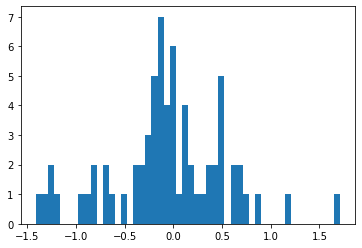

In [10]:
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.show()

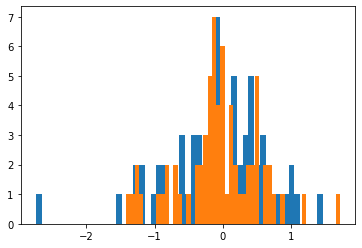

In [11]:
plt.hist(np.log10(np.abs(((torch.rand(len(q))*(-2) - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=50)
plt.show()

In [12]:
np.sum(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q))).numpy() < 1)/len(q)

0.5882352941176471

In [13]:
np.sum(np.abs(((torch.rand(len(q))*(-2) - torch.log10(q))/torch.log10(q))).numpy() < 1)/len(q)

0.5882352941176471

In [14]:
torch.mean((pred[:, 2] - torch.log10(q))**2)

tensor(0.5363)

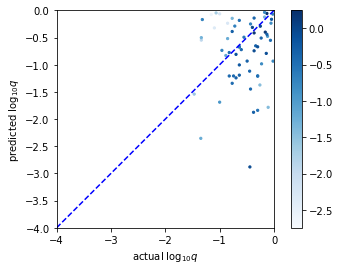

tensor([-0.3010, -1.0969, -0.1308, -0.1739, -0.6990])
[-1.2047405  -0.32283813 -0.44039744 -0.12250823 -0.8092734 ]
mse of log10q:  0.536281943321228


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(torch.log10(q), pred.numpy()[:, 2], s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(q)[-5:])
print(pred.numpy()[-5:, 2])
print('mse of log10q: ', torch.mean((torch.log10(q) -  pred.numpy()[:, 2])**2, dim=0).detach().cpu().item())

tensor(0.0700) tensor(0.8383)


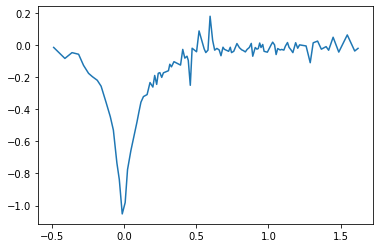

In [16]:
num = 20
print(q[num], 10**pred[num, 2])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.show()

In [17]:
# train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even[[num], :-120])

In [18]:
pi, normal = model(train_coeffs[[num]].float().to(device))

In [19]:
sample = model.sample(pi, normal).cpu().numpy()
print(sample)
print(torch.log10(q[num]))

[[ 0.9330627  -2.9082856  -0.7201545   0.45041746  3.272409   -0.1488139 ]]
tensor(-1.1549)


In [117]:
# qsnormal = torch.distributions.Normal(normal.loc[:, :, [0, 3]], normal.scale[:, :, [0, 3]])
qsnormal = torch.distributions.Normal(normal.loc[:, :, [2, 3]], normal.scale[:, :, [2, 3]])
grid = torch.stack(torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
# grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
# y = torch.tile(Y[[num]], [10000, 1])
# y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, qsnormal, grid[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [118]:
torch.exp(-get_negloglik(pi, normal, torch.log10(q)[[num]].to(device))).detach().cpu(), \
torch.exp(-get_negloglik(pi, normal, model.sample(pi, normal)[:, 2].to(device)).detach().cpu()), \
torch.exp(-model.mdn_loss(pi, normal, model.sample(pi, normal).to(device)).detach().cpu())

(tensor([0.0903]), tensor([0.4548]), tensor(15.4050))

tensor(-1.1549)
[[ 2.8320417  -2.4294658  -3.2956717   0.40804076 -0.77100515 -0.91890925]]


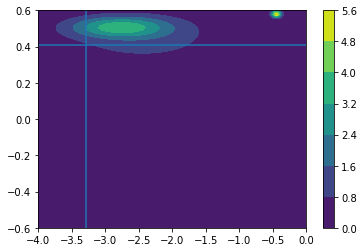

In [135]:
sample = model.sample(pi, normal).detach().cpu().numpy()
x, y = torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100))
# x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100))
plt.contourf(x, y, prob.reshape(100, 100))
# plt.contourf(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100), prob.reshape(100, 100).T)
# plt.hlines(Y[num, 3], 0, 1, colors='red')
# plt.vlines(Y[num, 0], -0.6, 0.6, colors='red')
# plt.hlines(sample[0, 3], 0, 1)
# plt.vlines(sample[0, 0], -0.6, 0.6)
plt.hlines(sample[0, 3], -4, 0)
plt.vlines(sample[0, 2], -0.6, 0.6)
plt.colorbar()
print(torch.log10(q)[num])
print(sample)

In [120]:
import MulensModel as mm
sample = model.sample(pi, normal).detach().cpu().numpy()
fs = 0.05
parameters = {
        't_0': 8551.968,
        't_E': 236.02,
        'u_0': 0.0390,
        'rho': 0.0028, 
        'q': 0.234, 
        's': 3.674, 
        'alpha': 3.105/np.pi*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-3*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-3*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
mag = - 2.5 * np.log10(fs*magnification + 1-fs) / 0.2
lc = np.stack([times, mag], axis=-1)

In [121]:
sample = model.sample(pi, normal).detach().cpu().numpy()
# fs = 1
parameters = {
        't_0': 8551.968,
        't_E': 236.02,
        'u_0': 0.039,
        'rho': 0.0028, 
        'q': 10**sample[0, 2], 
        's': 10**sample[0, 3], 
        'alpha': 3.105/np.pi*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-3*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-3*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
mag = -2.5 * np.log10(fs*magnification + 1-fs) / 0.2
lc_pred = np.stack([times, mag], axis=-1)

tensor(0.0700) 0.0001233012999074869


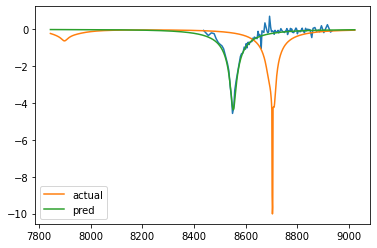

In [122]:
print(q[num], 10**sample[0, 2])
plt.plot(X_even[num, :, 0] * 236.02 * 4 + 8551.968, X_even[num, :, 1])
plt.plot(lc[:, 0], lc[:, 1], label='actual')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], label='pred')
plt.legend()
plt.show()

In [151]:
sample

array([[ 0.8640887 , -2.8583016 , -0.60997146,  0.4036388 , -0.92372173,
        -0.35998553]], dtype=float32)

In [161]:
Y = torch.tensor([0.039, np.log10(0.0028), np.log10(0.234), np.log10(3.674), np.cos(3.105), np.sin(3.105)]).reshape(1, -1)
print(Y)

tensor([[ 0.0390, -2.5528, -0.6308,  0.5651, -0.9993,  0.0366]],
       dtype=torch.float64)
